In [1]:
import cv2
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import filters
import numpy as np
from PIL import Image

In [50]:
def showpic(img, width=10):
    """display image"""
    plt.figure(figsize=(width, width / 1000 * 727))
    plt.imshow(img, cmap='gray')   
    plt.axis('off')   
    plt.show()
    plt.clf()

def my_contrast_stretch(img):
    """contrast stretching/normalization"""
    if img.dtype == np.float64:
        img = (img * 255).astype(np.uint8)
    M = np.max(img)
    m = np.min(img)
    res = img - m
    res = res * (255 / (M - m))
    return res.astype(np.uint8)

# First set of examples

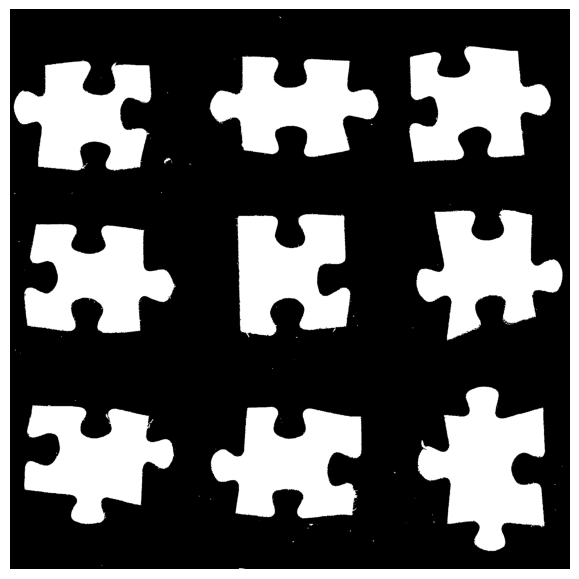

In [3]:
puzzle = np.array(Image.open('../data/multiple.jpg').convert('RGB'))
#showpic(puzzle)

# thresholding/binarization
thresh = cv2.cvtColor(puzzle, cv2.COLOR_RGBA2GRAY)
thresh = my_contrast_stretch(thresh)
thresh = thresh <= thresh.mean()
#showpic(thresh)


# find contours
thresh = cv2.cvtColor(puzzle, cv2.COLOR_RGBA2GRAY)
ret2,th3 = cv2.threshold(thresh,80,255,cv2.THRESH_BINARY)
contours, hierarchy = cv2.findContours(th3.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

h, w = th3.shape[:2]
vis = np.zeros((h, w, 3), np.uint8)
cv2.drawContours(vis, contours, -1, (255,255,255), -1)
showpic(vis)

In [4]:
# split image in tiles representing 1 piece each

tile_size = 1000
tiles = []
for i in range(len(contours)):
    if len(contours[i]) < 100:
        continue
    x, y, w, h = cv2.boundingRect(contours[i]) 
    shape, tile = np.zeros(thresh.shape[:2]), np.zeros((tile_size,tile_size), 'uint8') 
    cv2.drawContours(shape, [contours[i]], -1, color=1, thickness=-1)
    
    shape = (vis[:,:,1] * shape[:,:])[y:y+h, x:x+w] 
    tile[(tile_size-h)//2 : (tile_size-h)//2+h , (tile_size-w)//2 : (tile_size-w)//2+w] = shape  
    tiles.append(tile) 

In [88]:
def cart2pol(x, y):
    """cartesian to polar coordinates"""
    rho = np.sqrt(x ** 2 + y ** 2)
    phi = np.arctan2(y, x)
    return rho, phi

def pol2cart(rho, phi):
    """polar to cartesian coordinates"""
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

def smooth(y, box_pts):
    "smoothes the function"
    box = np.ones(box_pts)/box_pts
    
    padding = box_pts//2
    # mode same to keep the same number of points
    y_smooth = np.convolve(y, box, mode='valid')
    return np.append(y[:padding], np.append(y_smooth, [y[len(y) - padding:]]))

def max_pairwise_distance(contour):
    points = contour[:, 0, :]  # reshape to (N, 2) if needed
    dists = pdist(points)  # pairwise Euclidean distances
    return np.max(dists)

In [89]:
def do_classification(puzzle_piece, show_plots=True):
    img = puzzle_piece.copy()
    img = median_filter(img.astype('uint8'), size=15)
    if show_plots:
        showpic(img)
    contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_length = len(contours[0])
    
    display(Markdown(f"contour_lenght: {contour_length}"))
    (center_x, center_y), _ = cv2.minEnclosingCircle(contours[0])
    piece_diameter = max_pairwise_distance(contours[0])

    # get contour points in polar coordinates
    rhos = []
    phis = []
    for i in range(len(contours[0])):
        x, y = contours[0][i][0]
        rho, phi = cart2pol(x - center_x, y - center_y)
        rhos.append(rho)
        phis.append(phi)

    # apply smoothing to get rid of artifacts and paper fibres
    rhos = smooth(rhos, 5) # adjust the smoothing amount if necessary
    
    tenth_of_signal = len(rhos)//10
    
    rhos = np.append(rhos, [rhos[:tenth_of_signal]])
    rhos.flatten()
    # display(Markdown(str(rhos.shape)))
    
    
    # plt.hist(rhos, density=True, bins=len(rhos))  # density=False would make counts
    # plt.ylabel('Dist from piece center (px)')
    # plt.xlabel('Contour point')
    
    # compute number of "knobs"
    peaks, peak_props = find_peaks(rhos, height=0, prominence=20, distance=30)
    # display(Markdown(str(len(rhos))))
    # display(Markdown(str(peaks)))
    # display(Markdown(str(peak_props)))
    # display(Markdown(str(len(peaks))))
    display(Markdown(str(peaks)))
    display(Markdown(str([peak % contour_length for peak in peaks])))
    
    double_peaks = 0
    peak_points = []
    for peak in peaks:
        # x, y = pol2cart(rhos[peak], phis[peak])
        # peak_points.append([x + center_x, y + center_y])
        if peak >= contour_length:
            peak = peak % contour_length
            if peak in peaks:
                double_peaks += 1
                continue
        peak_points.append(contours[0][peak][0])
    peak_points = np.array(peak_points)
    # display(Markdown(str(peaks)))
    # display(Markdown(str(rhos)))
    
    if show_plots:
        plt.clf()
        plt.imshow(img)
        plt.plot(center_x, center_y, "og", markersize=5)  # og:shorthand for green circle
        for peak_point in peak_points:
            plt.plot([center_x, peak_point[0]], [center_y, peak_point[1]])
        plt.scatter(peak_points[:, 0], peak_points[:, 1], marker="x", color="red", s=40)
        plt.show()
        plt.clf()
        
        plt.plot(rhos)
        plt.plot(peaks, rhos[peaks], "x")
        plt.plot(np.zeros_like(rhos), "--", color="gray")
        plt.show()
        plt.clf()
    
    n_knobs = len(peaks) - 4 - double_peaks
    # adjust those cases where the peak is at the borders
    # if rhos[-1] >= rhos[-2] and rhos[0] >= rhos[1]:
    #     n_knobs += 1
    
    # compute number of "holes"
    rhos[rhos >= piece_diameter/4] = rhos.max()
    rhos = 0 - rhos + abs(rhos.min())
    peaks_2, peak_props_2 = find_peaks(rhos, prominence=20, distance=30)
    n_holes = len(peaks_2)
    
    peak_points = []  
    for peak in peaks_2:
        # x, y = pol2cart(rhos[peak], phis[peak])
        # peak_points.append([x + center_x, y + center_y])
        peak_points.append(contours[0][peak][0])
    peak_points = np.array(peak_points)
    
    if show_plots:
        plt.clf()
        plt.imshow(img)
        plt.plot(center_x, center_y, "og", markersize=5)  # og:shorthand for green circle
        plt.scatter(peak_points[:, 0], peak_points[:, 1], marker="x", color="red", s=40)
        plt.show()
        plt.clf()
        
        plt.plot(rhos)
        plt.plot(peaks_2, rhos[peaks_2], "x")
        plt.plot(np.zeros_like(rhos), "--", color="gray")
        plt.show()
        plt.clf()
    
    
    
    img_info = f"knobs: {n_knobs}, holes: {n_holes}"
    
    # classify piece
    n_features = n_knobs + n_holes
    if n_features > 4 or n_features < 0:
        img_info = "ERROR: " + img_info
    if n_features == 4:
        img_info = "Central piece: " + img_info
    if n_features == 3:
        img_info = "Border piece: " + img_info
    if n_features == 2:
        img_info = "Corner piece: " + img_info
        
    display(Markdown(img_info))
   

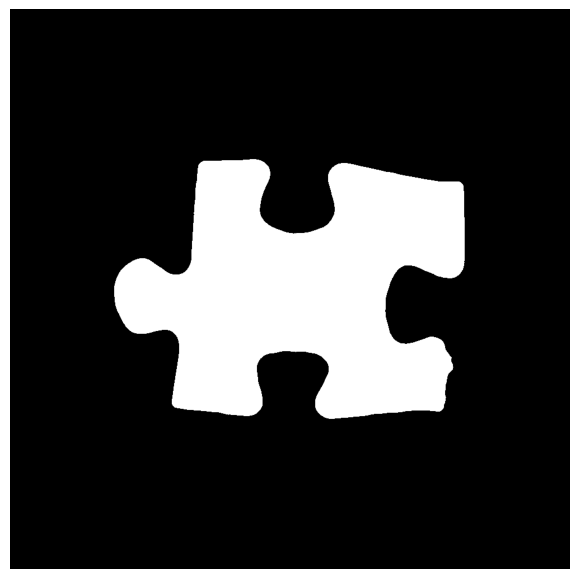

contour_lenght: 968

[  9 136 236 465 711 977]

[np.int64(9), np.int64(136), np.int64(236), np.int64(465), np.int64(711), np.int64(9)]

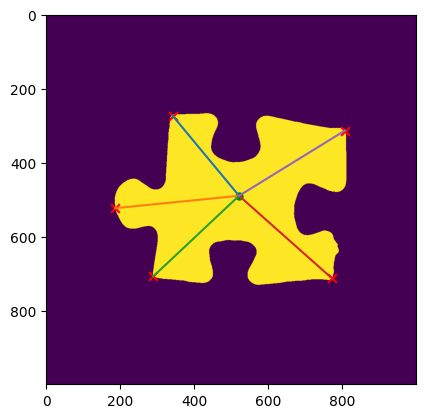

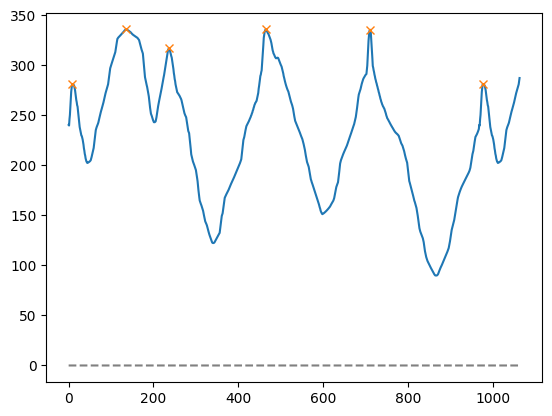

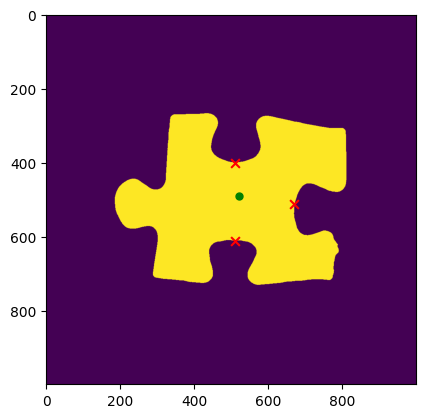

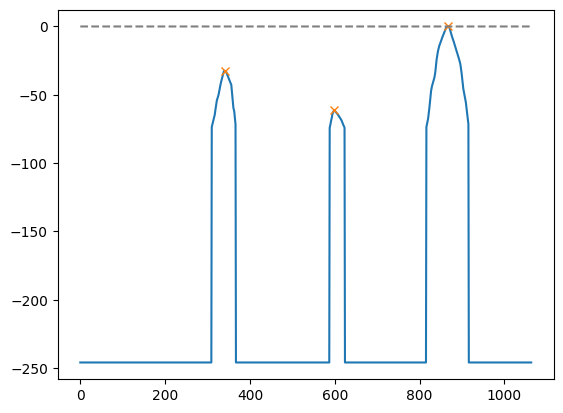

Central piece: knobs: 1, holes: 3

<Figure size 640x480 with 0 Axes>

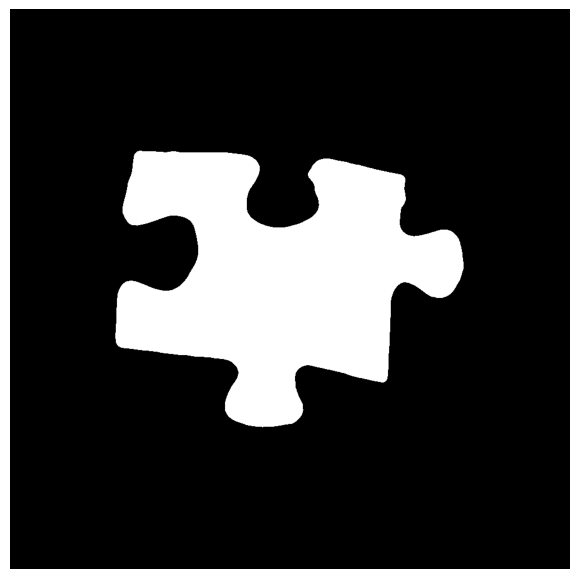

contour_lenght: 1025

[ 256  393  538  656  757 1028]

[np.int64(256), np.int64(393), np.int64(538), np.int64(656), np.int64(757), np.int64(3)]

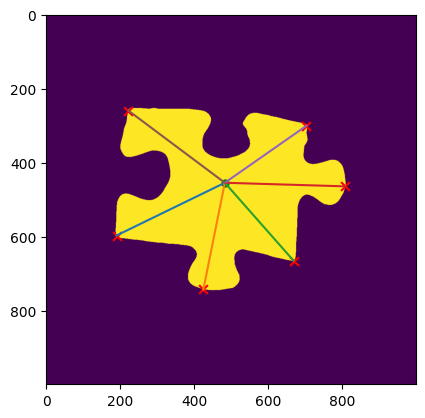

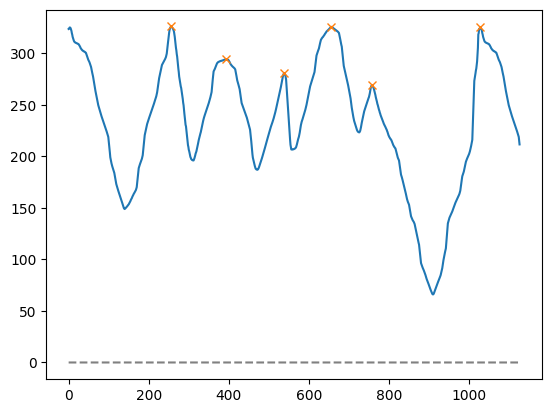

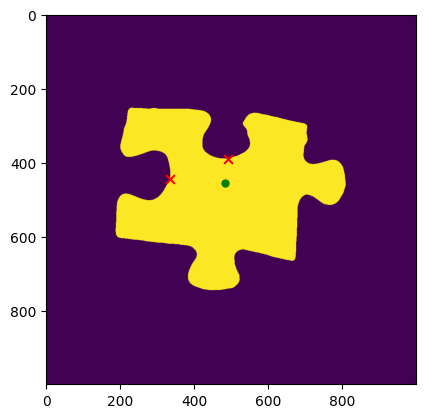

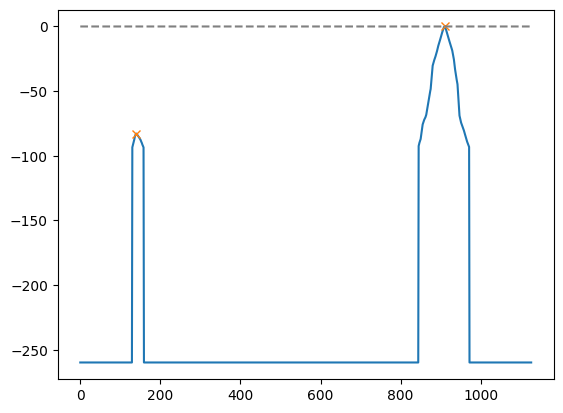

Central piece: knobs: 2, holes: 2

<Figure size 640x480 with 0 Axes>

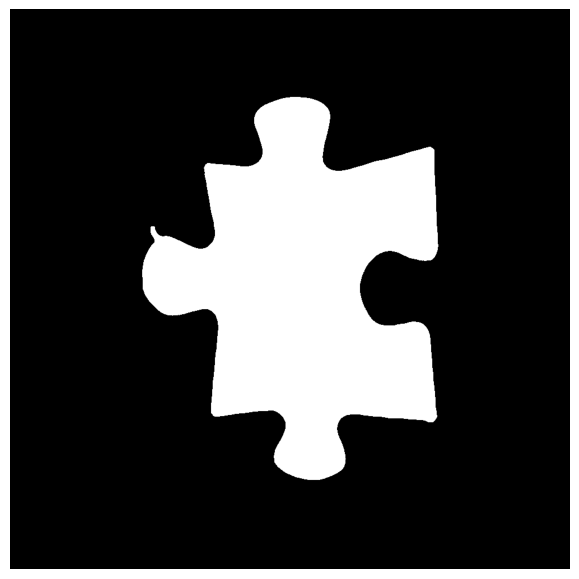

contour_lenght: 1017

[ 108  238  386  508  628  849 1017]

[np.int64(108), np.int64(238), np.int64(386), np.int64(508), np.int64(628), np.int64(849), np.int64(0)]

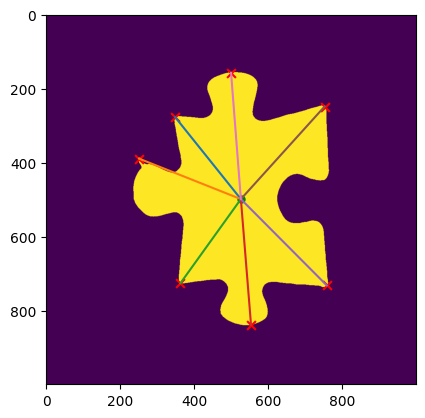

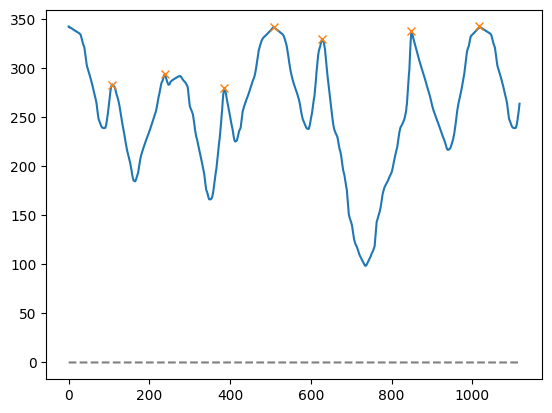

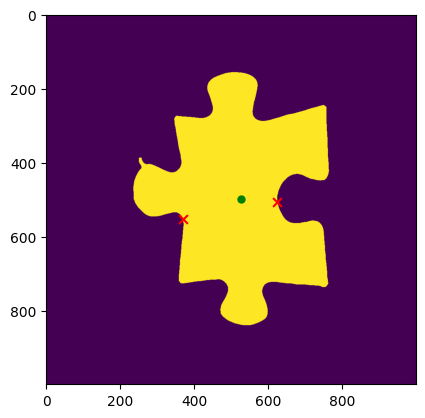

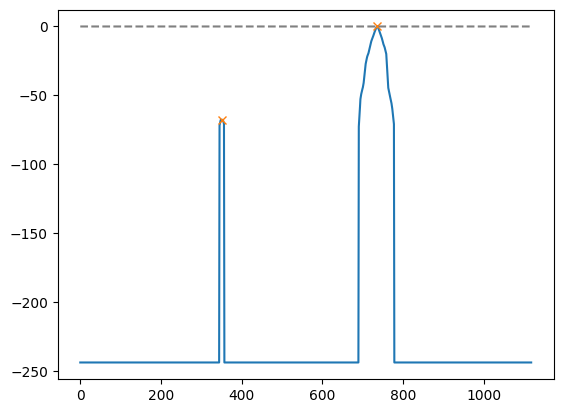

ERROR: knobs: 3, holes: 2

<Figure size 640x480 with 0 Axes>

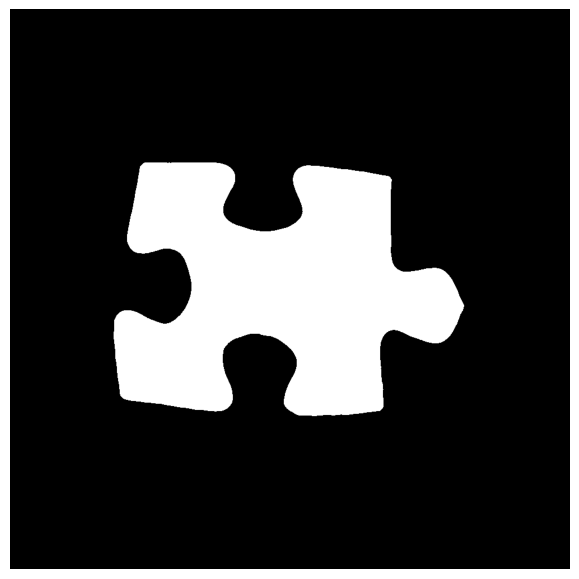

contour_lenght: 1022

[ 260  538  676  782 1024]

[np.int64(260), np.int64(538), np.int64(676), np.int64(782), np.int64(2)]

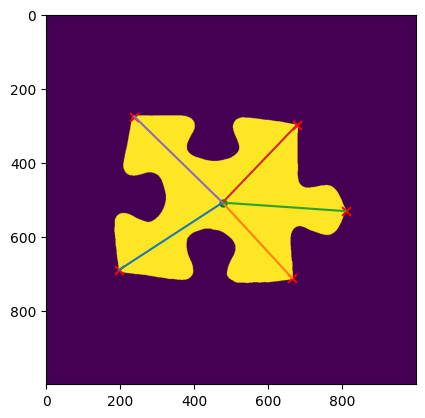

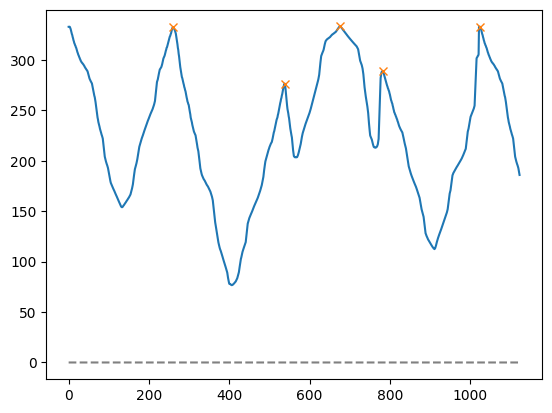

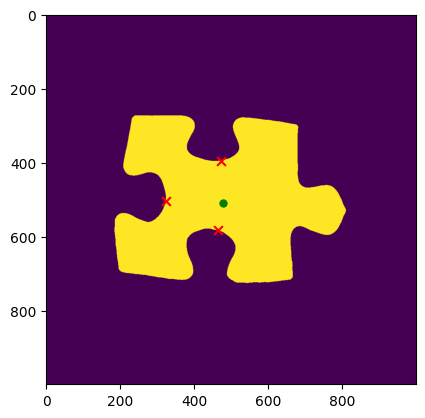

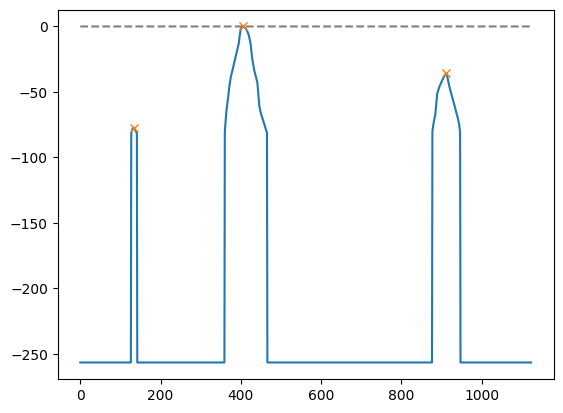

Central piece: knobs: 1, holes: 3

<Figure size 640x480 with 0 Axes>

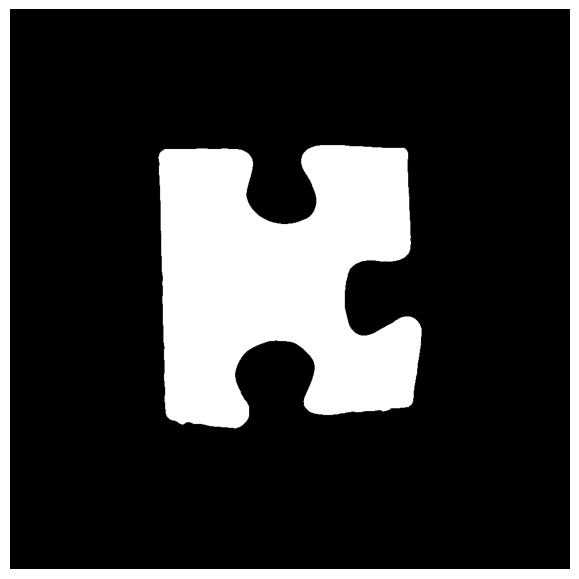

contour_lenght: 795

[205 270 554 782]

[np.int64(205), np.int64(270), np.int64(554), np.int64(782)]

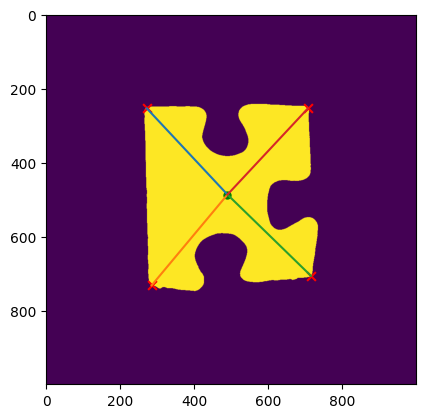

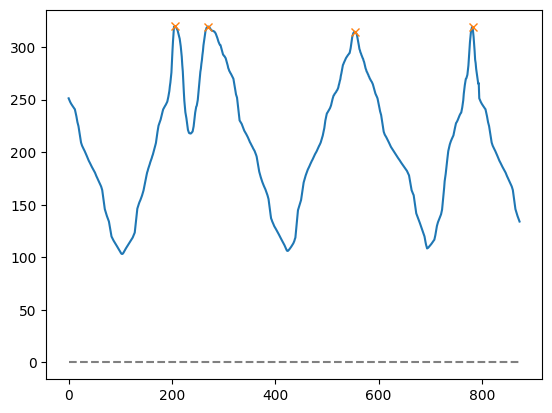

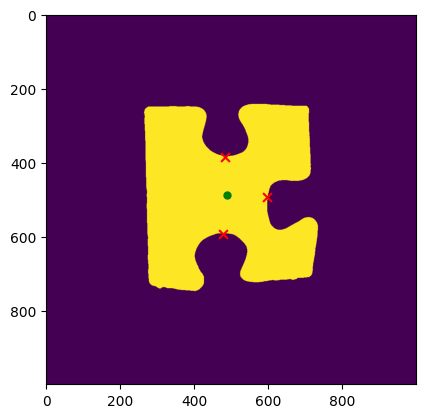

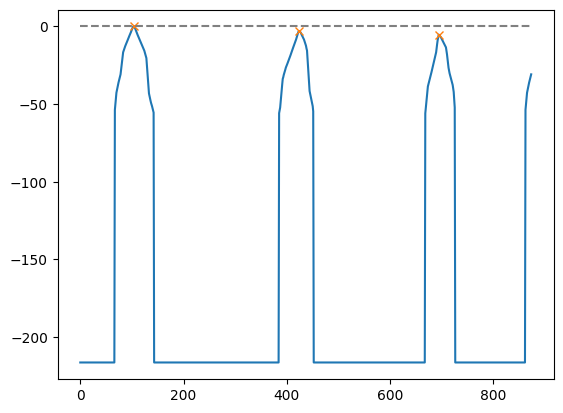

Border piece: knobs: 0, holes: 3

<Figure size 640x480 with 0 Axes>

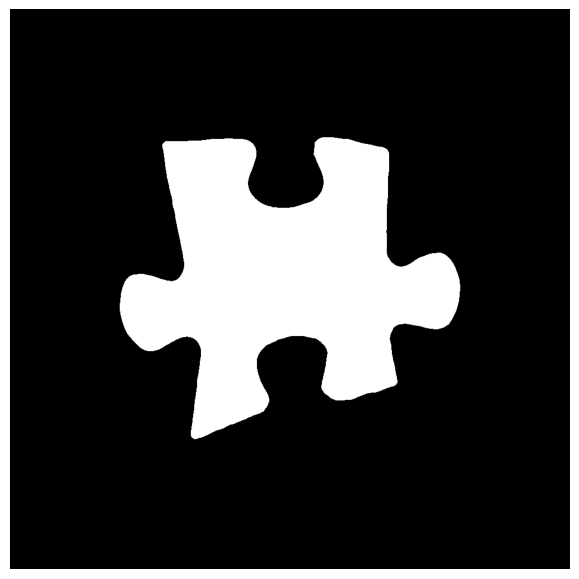

contour_lenght: 1081

[ 192  350  491  800  918 1041]

[np.int64(192), np.int64(350), np.int64(491), np.int64(800), np.int64(918), np.int64(1041)]

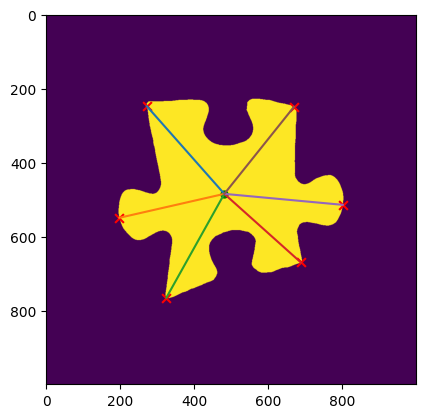

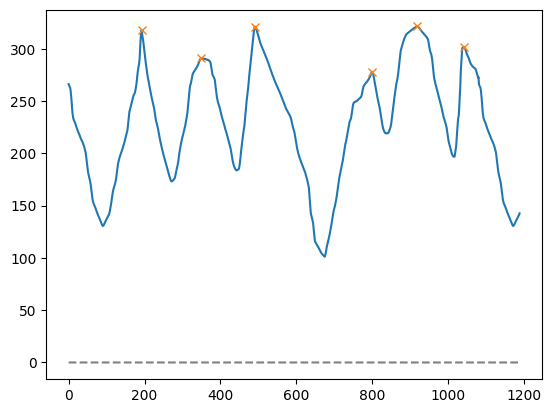

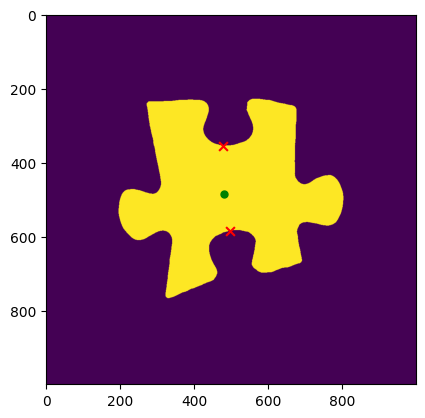

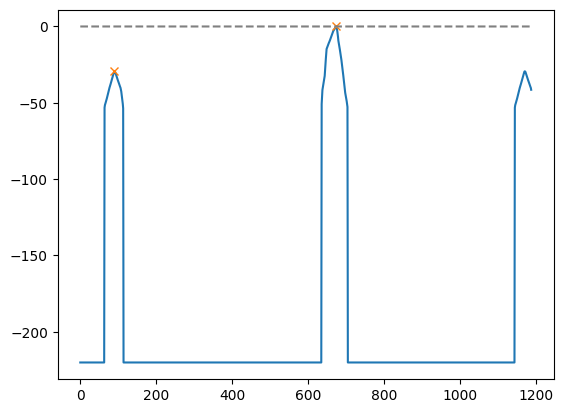

Central piece: knobs: 2, holes: 2

<Figure size 640x480 with 0 Axes>

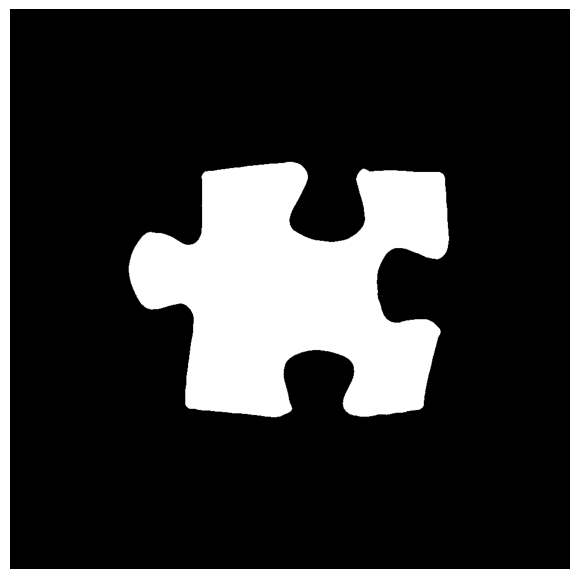

contour_lenght: 992

[  36  141  264  519  766 1028]

[np.int64(36), np.int64(141), np.int64(264), np.int64(519), np.int64(766), np.int64(36)]

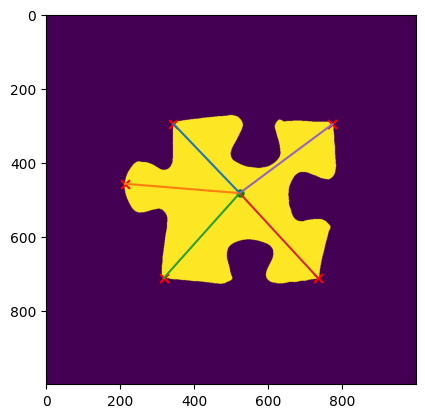

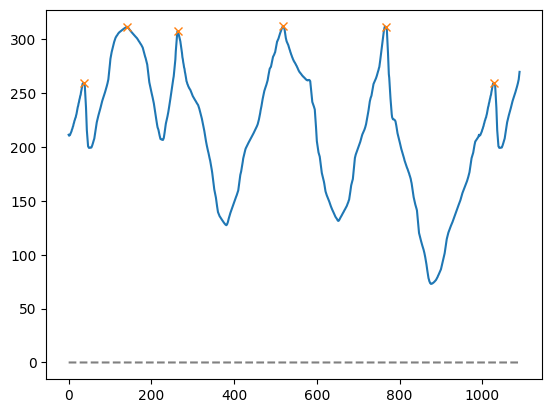

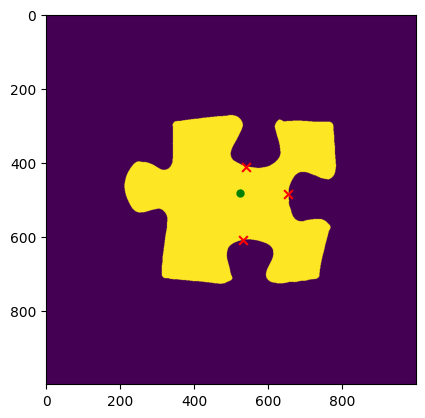

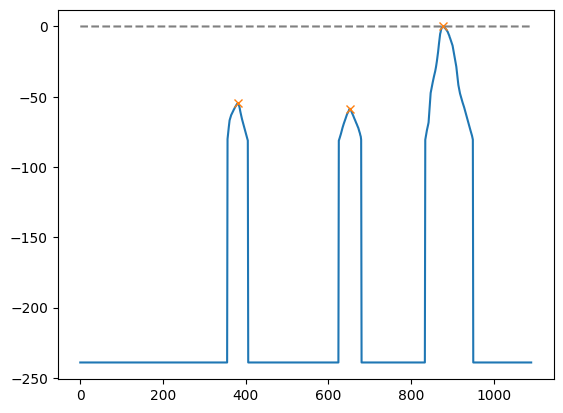

Central piece: knobs: 1, holes: 3

<Figure size 640x480 with 0 Axes>

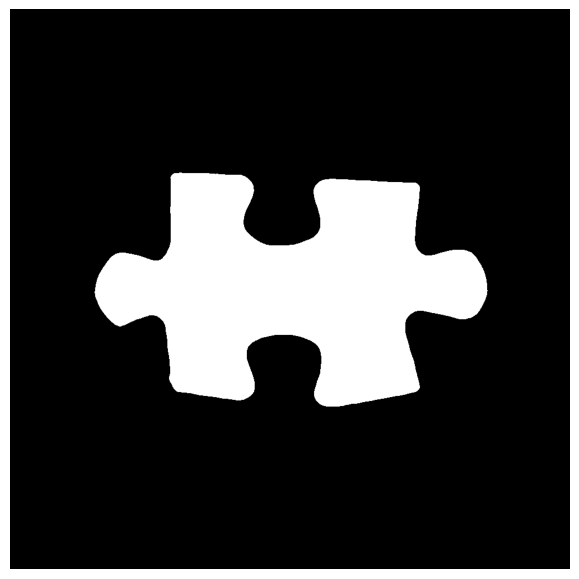

contour_lenght: 918

[111 237 482 625 723 923]

[np.int64(111), np.int64(237), np.int64(482), np.int64(625), np.int64(723), np.int64(5)]

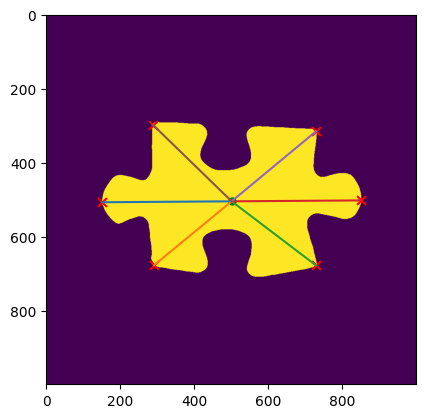

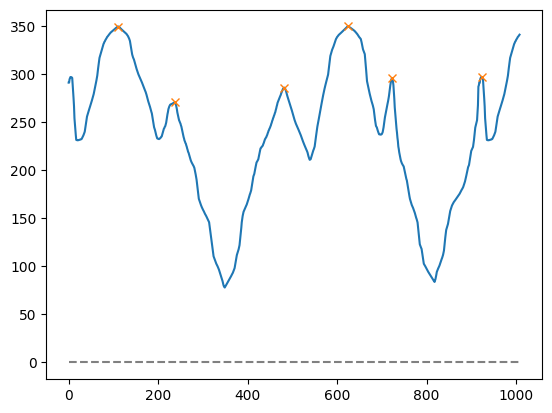

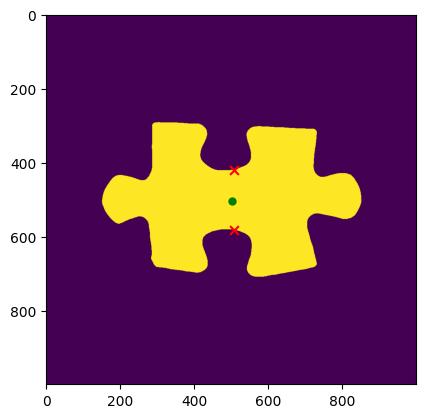

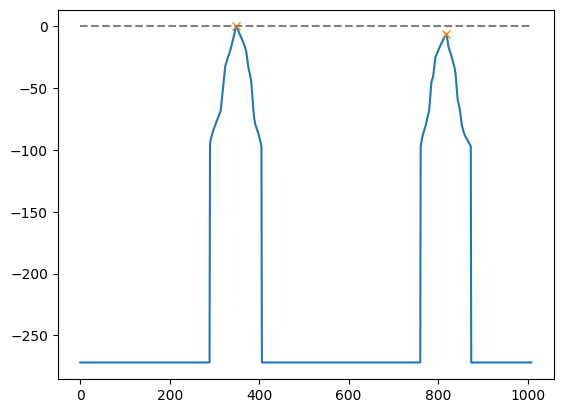

Central piece: knobs: 2, holes: 2

<Figure size 640x480 with 0 Axes>

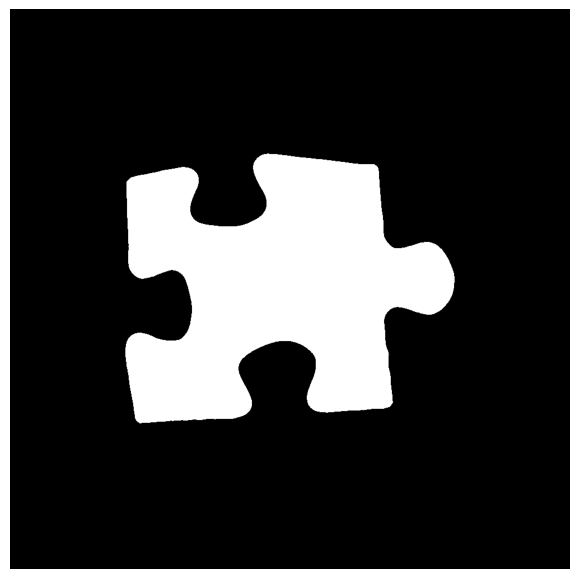

contour_lenght: 990

[215 439 715 840 949]

[np.int64(215), np.int64(439), np.int64(715), np.int64(840), np.int64(949)]

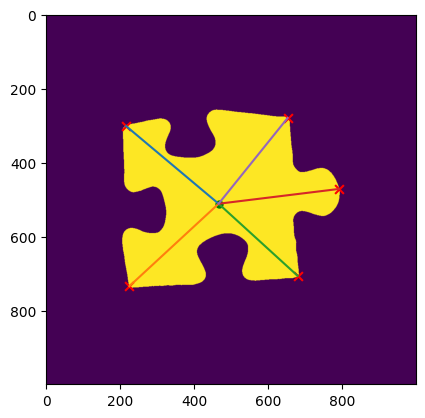

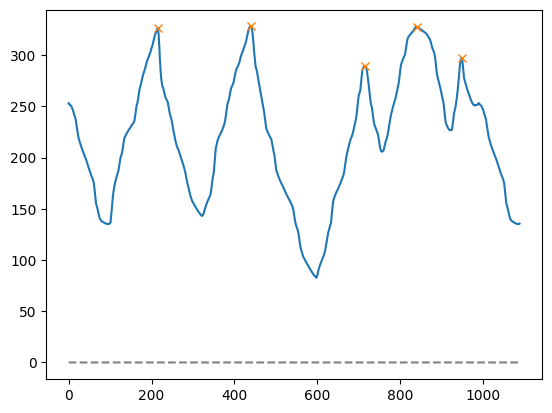

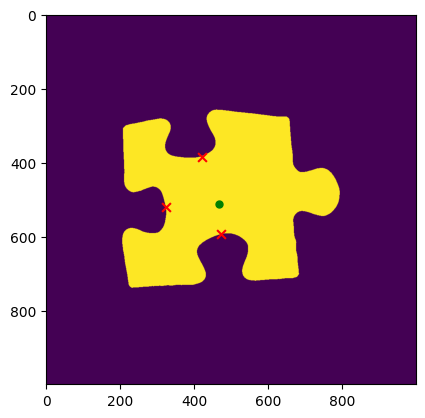

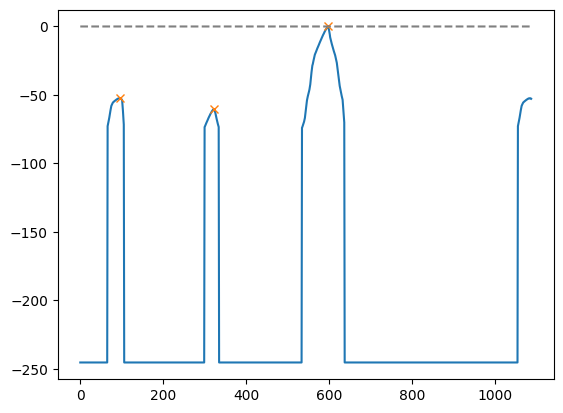

Central piece: knobs: 1, holes: 3

<Figure size 640x480 with 0 Axes>

In [92]:
from IPython.display import display, Markdown
from scipy.ndimage import median_filter
from scipy.spatial.distance import pdist

for puzzle_piece in tiles:
    do_classification(puzzle_piece, show_plots=True)
    

(array([123, 222, 458, 695]), {'peak_heights': array([333.5073417 , 302.15273652, 324.97175162, 304.72565361])})